<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/image_super_resolution/blob/master/estimating_optical_flow_image_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computing the (average) energy of the full-resolution SRLs of the DWT domain

In [1]:
# Load an image

import urllib.request
import cv2
import numpy as np
import math

HTTP_response = urllib.request.urlopen('http://www.hpca.ual.es/~vruiz/images/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BGR = cv2.imdecode(arr,-1)
image = cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB)

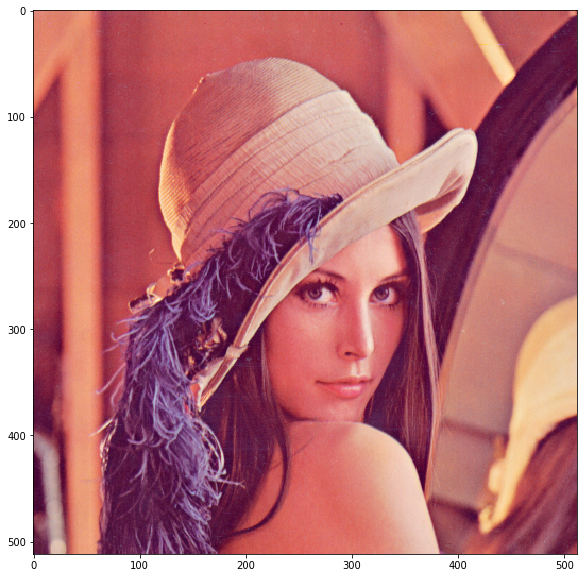

In [2]:
# Display it

from matplotlib import pyplot as plt
%matplotlib inline

def show(img):
    plt.figure(figsize = (10,10))
    plt.imshow((img-img.min())/(img.max()-img.min()))
    
show(image)

In [3]:
# Define the Wavelet kernel

import pywt

print (pywt.wavelist())

# Seleccionamos una en concreto 
#wavelet = 'db9' # http://wavelets.pybytes.com/wavelet/db9/
#wavelet = 'db5' # http://wavelets.pybytes.com/wavelet/db9/
#wavelet = 'haar'
#wavelet='rbio3.5'
#wavelet='rbio1.1'
wavelet='bior3.5'
#wavelet='coif7'
#wavelet='coif5'
mode='per'

def DWT(image):
    return pywt.dwt2(image, wavelet, mode)
  
def iDWT(L, H):
    return pywt.idwt2((L, H), wavelet, mode)

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3

In [4]:
# DWT of the image. We define a recursive structure L^l = (L^(l+1), H^(l+1)) where each H is a tuple with 3 subbands. Each component is processed independently.

levels = 5

L = cv2.split(image)
H = levels*[None]
for l in range(levels):
    H[l] = 3*[None]
    for c in range(3):
        L[c], H[l][c] = DWT(L[c])

#show(cv2.merge(L))


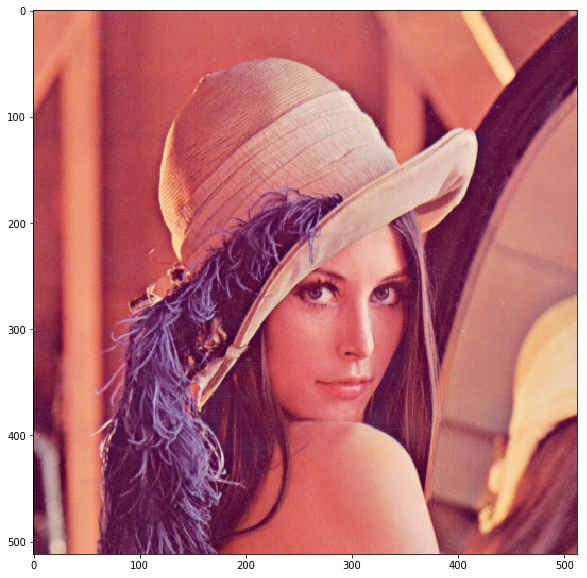

In [5]:
# Debug cell. iDWT (only for the sake of testing the forward transform)

tmp = L.copy()
for l in range(levels-1, -1, -1):
  for c in range(3):
    tmp[c] = iDWT(tmp[c], H[l][c])

show(cv2.merge(tmp))

In [6]:
# iDWT all resolutions. R[] is a list with all the available spatial resolution levels. Thus, if levels = 3, we get 4 different reconstructions with a dyadic resolution.

R = (levels+1)*[None]
R[levels] = L.copy()
for c in range(3):
  R[levels][c] = L[c].copy()
for l in range(levels-1, -1, -1):
  R[l] = 3*[None]
  for c in range(3):
    R[l][c] = iDWT(R[l+1][c], H[l][c])
  #show(cv2.merge(R[l]))

In [7]:
# Debug cell

for l in range(levels+1):
  for c in range(3):
    print(l, R[l][c].shape)

0 (512, 512)
0 (512, 512)
0 (512, 512)
1 (256, 256)
1 (256, 256)
1 (256, 256)
2 (128, 128)
2 (128, 128)
2 (128, 128)
3 (64, 64)
3 (64, 64)
3 (64, 64)
4 (32, 32)
4 (32, 32)
4 (32, 32)
5 (16, 16)
5 (16, 16)
5 (16, 16)


In [8]:
# Interpolate all resolution levels. This is the progressive rendering by spatial resolution levels.
iR = (levels+1)*[None]
for l in range(levels+1):
  iR[l] = R[l].copy()
  for c in range(3):
    iR[l][c] = R[l][c].copy()
  for ll in range(l):
    for c in range(3):
      iR[l][c] = iDWT(iR[l][c], (None, None, None))
  #show(cv2.merge(iR[l]))

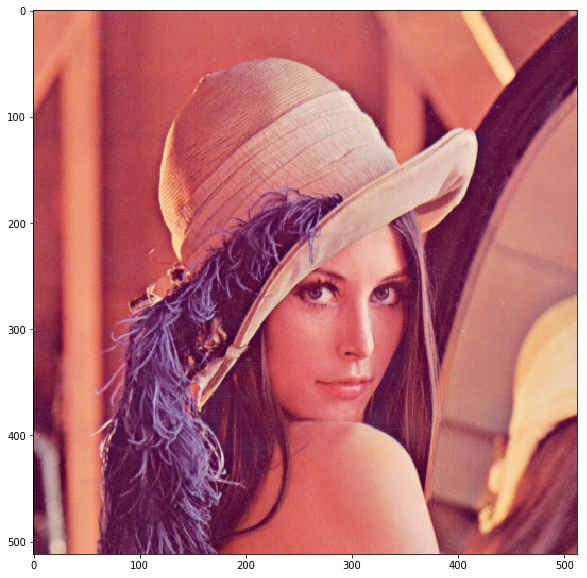

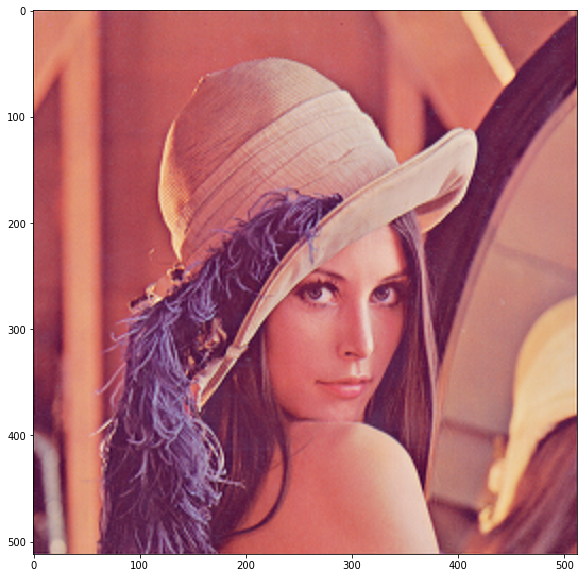

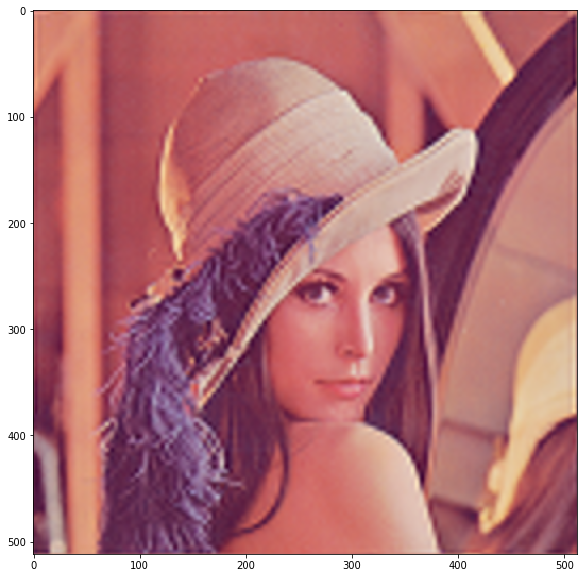

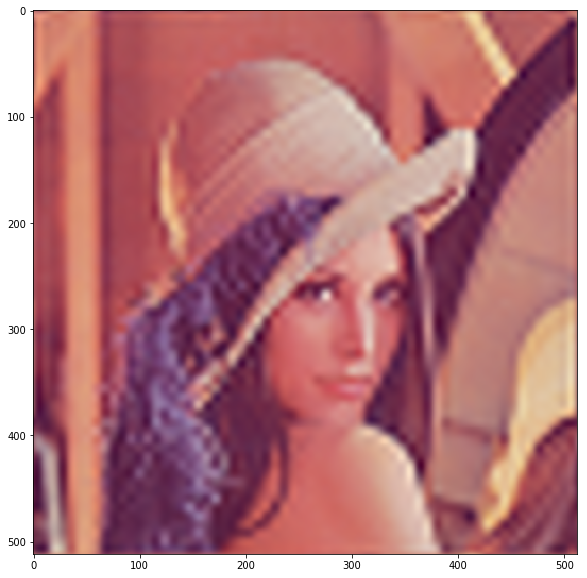

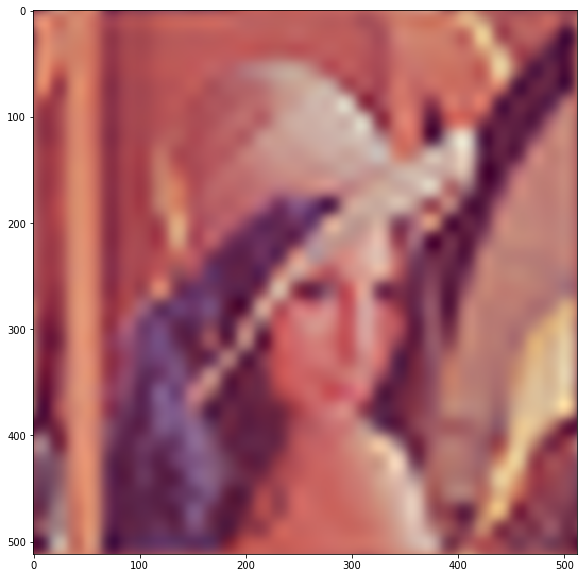

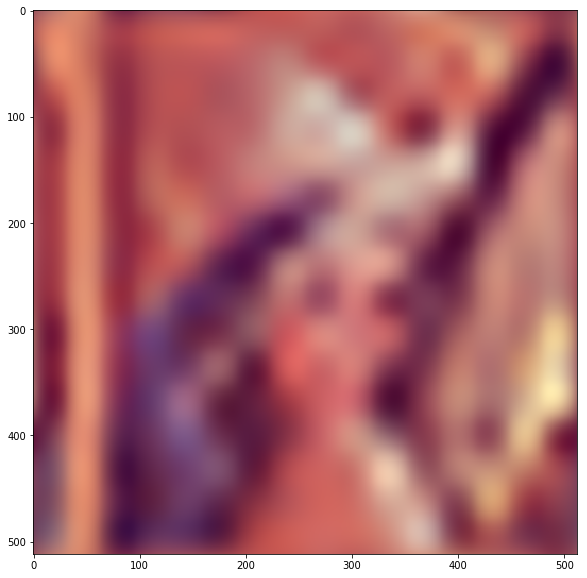

In [9]:
# Show SRLs
for l in range(levels+1):
  show(cv2.merge(iR[l]))

In [10]:
# Compute the average energy
def component_energy(component):
    return np.sum(component*component)/(component.shape[0]*component.shape[1])

def image_energy(image):
    return (component_energy(image[0]) + component_energy(image[1]) + component_energy(image[2]))/3

for l in range(levels+1):
    energy = image_energy(iR[l])
    print(energy, math.sqrt(energy))

19922.196701049805 141.14601199130567
19892.950572441445 141.04237154997588
19839.82034021632 140.85389714245156
19745.62303643188 140.51911982513937
19571.73030214157 139.89900036148066
19352.30728960045 139.11257056643174


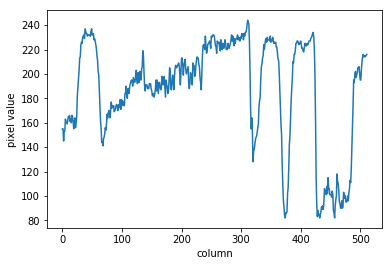

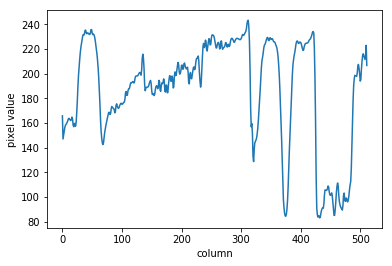

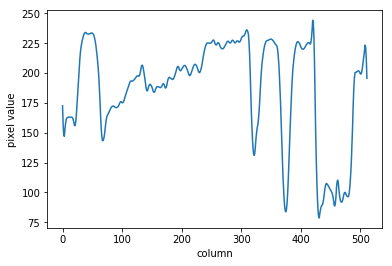

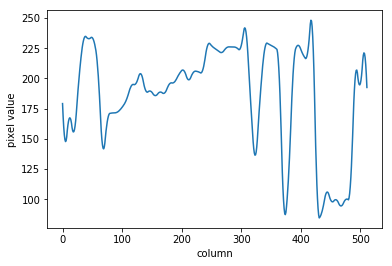

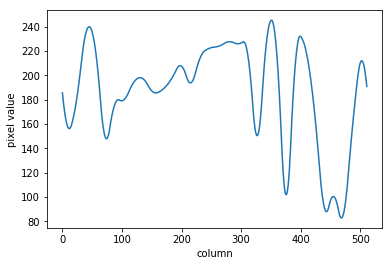

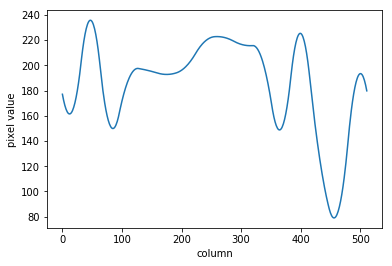

In [11]:
for l in range(levels+1):
    plt.plot(iR[l][0][100,:])
    plt.ylabel('pixel value')
    plt.xlabel('column')
    plt.show()